# Image Classification: Detecting Pediatric Pneumonia

## Overview

## Business Understanding

## Data Understanding

## Data Preparation

In [178]:
#importing packages
import pandas as pd 
import splitfolders
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os

from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import load_model
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.model_selection import cross_val_score
from tensorflow.keras import metrics
from tensorflow.keras.wrappers import scikit_learn

from tensorflow.keras.layers import Dense
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay


seed = 42
tf.random.set_seed(seed)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [3]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook


#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [179]:
# Using ImageDataGenerator to rescale all images 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [180]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=3747,
        color_mode='grayscale',
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 3747 images belonging to 2 classes.


In [181]:
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=936,
                                                        color_mode='grayscale',
                                                        class_mode='binary')
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 936 images belonging to 2 classes.
Found 1173 images belonging to 2 classes.


In [182]:
#Creating the augumented data

aug_train_images = ImageDataGenerator(rotation_range=30, 
                                   width_shift_range=0.25, 
                                   height_shift_range=0.25, 
                                   shear_range=0.25, 
                                   zoom_range=0.25, 
                                   horizontal_flip=True,
                                   vertical_flip=True)

train_aug = aug_train_images.flow_from_directory('Data_Split/train',
                                                  target_size=(150, 150),
                                                  batch_size=3747,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

Found 3747 images belonging to 2 classes.


In [183]:
#getting images and labels for models
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [188]:
#reshaping
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
val_data = val_data.reshape(val_data.shape[0], -1)
train_data.shape

(3747, 22500)

In [10]:
# Function to show model metrics

### Dummy Model
We will use a dummy model classifier as our baseline model. This model will predict the majority class. Since the majority class in our data is pneumonia, this model will predict all images are pneumonia.

In [12]:
dummy_model =  DummyClassifier(strategy='most_frequent')
dummy_model.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [13]:
y_preds_dummy = dummy_model.predict(val_data)

In [14]:
dummy_acc = dummy_model.score(val_data, val_labels)
dummy_rec = recall_score(val_labels,y_preds_dummy)
dummy_pre = precision_score(val_labels,y_preds_dummy)

print(f"Dummy Model accuracy: {dummy_acc}")
print(f"Dummy Model recall: {dummy_rec}")
print(f"Dummy Model precision: {dummy_pre}")

Dummy Model accuracy: 0.7297008547008547
Dummy Model recall: 1.0
Dummy Model precision: 0.7297008547008547


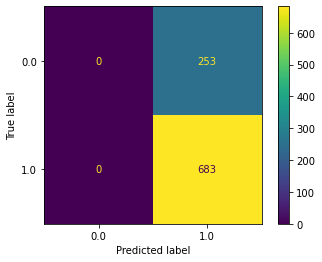

In [15]:
# Confusion matrix for dummy model
plot_confusion_matrix(dummy_model, val_data, val_labels);

### Simple Model 1
Our first model will be a simple model - this will give us an idea of what improvements

In [189]:
simple_model = models.Sequential()

In [190]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid')) 

In [191]:
simple_model.compile(optimizer='SGD',
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])
simple_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 12)                270012    
                                                                 
 dense_37 (Dense)            (None, 1)                 13        
                                                                 
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [192]:
simple_model_history = simple_model.fit(train_data, train_labels, epochs=10, 
                                    batch_size=32, validation_data= (val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 2s 11ms/step - loss: 0.5337 - accuracy: 0.7422 - precision_18: 0.7457 - recall_18: 0.9813 - val_loss: 0.7664 - val_accuracy: 0.7297 - val_precision_18: 0.7297 - val_recall_18: 1.0000
Epoch 2/10
118/118 [==============================] - 1s 8ms/step - loss: 0.3953 - accuracy: 0.8244 - precision_18: 0.8412 - recall_18: 0.9360 - val_loss: 0.4013 - val_accuracy: 0.8259 - val_precision_18: 0.9797 - val_recall_18: 0.7775
Epoch 3/10
118/118 [==============================] - 1s 8ms/step - loss: 0.3272 - accuracy: 0.8639 - precision_18: 0.8913 - recall_18: 0.9265 - val_loss: 0.2362 - val_accuracy: 0.9038 - val_precision_18: 0.9158 - val_recall_18: 0.9561
Epoch 4/10
118/118 [==============================] - 1s 9ms/step - loss: 0.2688 - accuracy: 0.8903 - precision_18: 0.9097 - recall_18: 0.9433 - val_loss: 0.7127 - val_accuracy: 0.6741 - val_precision_18: 1.0000 - val_recall_18: 0.5534
Epoch 5/10
118/118 [==============================] - 1

In [195]:
simple_model.evaluate(val_data, val_labels)

30/30 [==============================] - 0s 5ms/step - loss: 0.1683 - accuracy: 0.9316 - precision_18: 0.9365 - recall_18: 0.9722


[0.16830110549926758,
 0.9316239356994629,
 0.936530351638794,
 0.9721815586090088]

KeyError: 'precision'

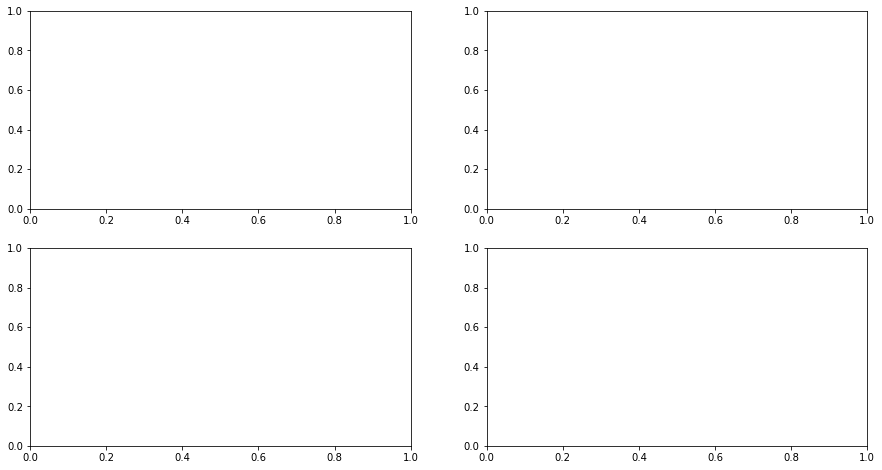

In [194]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

loss = simple_model_history.history['loss']
accuracy = simple_model_history.history['accuracy']
precision = simple_model_history.history['precision']
recall = simple_model_history.history['recall']

validation_loss = simple_model_history.history['val_loss']
validation_accuracy = simple_model_history.history['val_accuracy']
validation_precision = simple_model_history.history['val_precision']
validation_recall = simple_model_history.history['val_recall']

sns.lineplot(simple_model_history.epoch, simple_model_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')


sns.lineplot(simple_model_history.epoch, simple_model_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(simple_model_history.epoch, simple_model_history.history['val_recall'], y=recall, ax=ax4, label='val_recall')



### CNN Model 1
Our basic CNN model

In [92]:
train_data, train_labels = next (train_generator)
test_data, test_labels = next (test_generator)
val_data, val_labels = next (validation_generator)

In [94]:
cnn1_model = models.Sequential()
cnn1_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
cnn1_model.add(layers.MaxPooling2D((2, 2)))
cnn1_model.add(layers.Flatten())
cnn1_model.add(layers.Dense(16, activation='relu'))
cnn1_model.add(layers.Dense(1, activation='sigmoid'))

cnn1_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn1_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 341056)            0         
                                                                 
 dense_30 (Dense)            (None, 16)                5456912   
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
___________________________________________

In [95]:
cnn1_history = cnn1_model.fit(train_data,
               train_labels,
               batch_size=30,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
125/125 [==============================] - 125s 963ms/step - loss: 0.5152 - accuracy: 0.7659 - precision_15: 0.7876 - recall_15: 0.9301 - val_loss: 0.3016 - val_accuracy: 0.9188 - val_precision_15: 0.9523 - val_recall_15: 0.9356
Epoch 2/10
125/125 [==============================] - 119s 954ms/step - loss: 0.2884 - accuracy: 0.9223 - precision_15: 0.9272 - recall_15: 0.9696 - val_loss: 0.2679 - val_accuracy: 0.9466 - val_precision_15: 0.9717 - val_recall_15: 0.9546
Epoch 3/10
125/125 [==============================] - 117s 938ms/step - loss: 0.2498 - accuracy: 0.9421 - precision_15: 0.9468 - recall_15: 0.9755 - val_loss: 0.2513 - val_accuracy: 0.9391 - val_precision_15: 0.9728 - val_recall_15: 0.9429
Epoch 4/10
125/125 [==============================] - 121s 966ms/step - loss: 0.2285 - accuracy: 0.9506 - precision_15: 0.9576 - recall_15: 0.9755 - val_loss: 0.2189 - val_accuracy: 0.9551 - val_precision_15: 0.9638 - val_recall_15: 0.9751
Epoch 5/10
125/125 [====================

In [139]:
cnn1_model.save('models/cnn1')

INFO:tensorflow:Assets written to: models/cnn1/assets


INFO:tensorflow:Assets written to: models/cnn1/assets


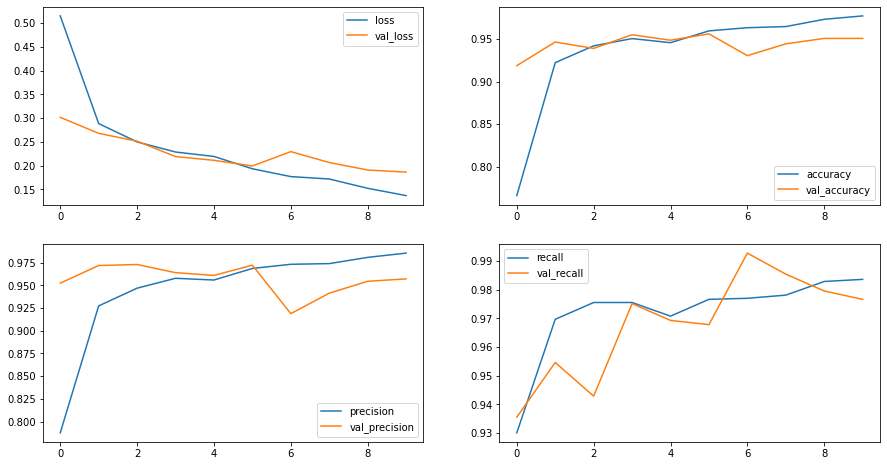

In [143]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn1_history.epoch, cnn1_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn1_history.epoch, cnn1_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn1_history.epoch, cnn1_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [201]:
results = cnn1_model.evaluate(validation_generator)

1/1 [==============================] - 25s 25s/step - loss: 0.1862 - accuracy: 0.9509 - precision_15: 0.9570 - recall_15: 0.9766


In [211]:
print(f"Model loss: {results[0]}")
print(f"Model accuracy: {results[1]}")
print(f"Model precision: {results[2]}")
print(f"Model recall: {results[3]}")

Model loss: 0.18623757362365723
Model accuracy: 0.9508547186851501
Model precision: 0.9569584131240845
Model recall: 0.9765739440917969


In [197]:
results_display[1]

0.9508547186851501

In [202]:
results[0]

0.18623757362365723

In [199]:
results_display[2]

0.9569584131240845

In [200]:
results_display[3]

0.9765739440917969

In [145]:
#CONFUSION MATRIX

## CNN Model 2
description

In [37]:
cnn2_model = models.Sequential()
cnn2_model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                            input_shape=(150,150,1)))
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Conv2D(32, (3,3), activation='relu'))       
cnn2_model.add(layers.MaxPooling2D((2,2)))
cnn2_model.add(layers.Flatten())
cnn2_model.add(Dense(16, activation='relu'))
cnn2_model.add(Dense(1, activation='sigmoid')) 

cnn2_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 41472)             0         
                                                                 
 dense_6 (Dense)             (None, 16)               

In [38]:
cnn2_history = cnn2_model.fit(train_data,
               train_labels,
               batch_size=50,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
75/75 [==============================] - 149s 2s/step - loss: 0.4024 - accuracy: 0.8110 - precision_3: 0.7990 - recall_3: 0.9901 - val_loss: 0.2805 - val_accuracy: 0.8921 - val_precision_3: 0.8789 - val_recall_3: 0.9883
Epoch 2/10
75/75 [==============================] - 132s 2s/step - loss: 0.2851 - accuracy: 0.9183 - precision_3: 0.9178 - recall_3: 0.9755 - val_loss: 0.2596 - val_accuracy: 0.9135 - val_precision_3: 0.9057 - val_recall_3: 0.9839
Epoch 3/10
75/75 [==============================] - 132s 2s/step - loss: 0.2569 - accuracy: 0.9341 - precision_3: 0.9365 - recall_3: 0.9759 - val_loss: 0.2489 - val_accuracy: 0.9455 - val_precision_3: 0.9647 - val_recall_3: 0.9605
Epoch 4/10
75/75 [==============================] - 134s 2s/step - loss: 0.2447 - accuracy: 0.9440 - precision_3: 0.9485 - recall_3: 0.9762 - val_loss: 0.2282 - val_accuracy: 0.9455 - val_precision_3: 0.9426 - val_recall_3: 0.9854
Epoch 5/10
75/75 [==============================] - 129s 2s/step - loss: 0.2

In [146]:
cnn2_model.save('models/cnn2')

INFO:tensorflow:Assets written to: models/cnn2/assets


INFO:tensorflow:Assets written to: models/cnn2/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn2_history.epoch, cnn2_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn2_history.epoch, cnn2_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn2_history.epoch, cnn2_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [151]:
cnn2_model.evaluate(validation_generator)

1/1 [==============================] - 34s 34s/step - loss: 0.1876 - accuracy: 0.9594 - precision_3: 0.9627 - recall_3: 0.9824


[0.18755219876766205,
 0.9594017267227173,
 0.9626972675323486,
 0.9824304580688477]

In [ ]:
CONFUSION MATRIX

### CNN Model 3

In [41]:
cnn3_model = models.Sequential()
cnn3_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
cnn3_model.add(layers.MaxPooling2D((2, 2)))
cnn3_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn3_model.add(layers.MaxPooling2D((2,2)))
cnn3_model.add(layers.Flatten())
cnn3_model.add(layers.Dense(16, activation='relu'))
cnn3_model.add(layers.Dense(1, activation='sigmoid'))

cnn3_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn3_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 39200)             0         
                                                                 
 dense_8 (Dense)             (None, 16)               

In [42]:
cnn3_history = cnn3_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 178s 1s/step - loss: 0.3261 - accuracy: 0.8564 - precision_4: 0.8641 - recall_4: 0.9532 - val_loss: 0.1803 - val_accuracy: 0.9241 - val_precision_4: 0.9665 - val_recall_4: 0.9283
Epoch 2/10
118/118 [==============================] - 165s 1s/step - loss: 0.1672 - accuracy: 0.9381 - precision_4: 0.9497 - recall_4: 0.9663 - val_loss: 0.1495 - val_accuracy: 0.9370 - val_precision_4: 0.9298 - val_recall_4: 0.9883
Epoch 3/10
118/118 [==============================] - 175s 1s/step - loss: 0.1488 - accuracy: 0.9466 - precision_4: 0.9591 - recall_4: 0.9682 - val_loss: 0.1588 - val_accuracy: 0.9359 - val_precision_4: 0.9860 - val_recall_4: 0.9253
Epoch 4/10
118/118 [==============================] - 189s 2s/step - loss: 0.1365 - accuracy: 0.9456 - precision_4: 0.9600 - recall_4: 0.9656 - val_loss: 0.1297 - val_accuracy: 0.9562 - val_precision_4: 0.9547 - val_recall_4: 0.9868
Epoch 5/10
118/118 [==============================] - 191s 2s/step -

In [147]:
cnn3_model.save('models/cnn3')

INFO:tensorflow:Assets written to: models/cnn3/assets


INFO:tensorflow:Assets written to: models/cnn3/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn3_history.epoch, cnn3_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn3_history.epoch, cnn3_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn3_history.epoch, cnn3_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [152]:
cnn3_model.evaluate(validation_generator)

1/1 [==============================] - 25s 25s/step - loss: 0.1227 - accuracy: 0.9509 - precision_4: 0.9636 - recall_4: 0.9693


[0.12268752604722977,
 0.9508547186851501,
 0.9636098742485046,
 0.9692533016204834]

### CNN Model 4

In [47]:
cnn4_model = models.Sequential()
cnn4_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2, 2)))
cnn4_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn4_model.add(layers.MaxPooling2D((2,2)))
cnn4_model.add(layers.Flatten())
cnn4_model.add(layers.Dense(16, activation='relu'))
cnn4_model.add(layers.Dense(1, activation='sigmoid'))

cnn4_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn4_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 39200)             0         
                                                                 
 dense_10 (Dense)            (None, 16)               

In [49]:
cnn4_history = cnn4_model.fit(train_data,
              train_labels,
              batch_size=32,
              epochs=10,
              validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 153s 1s/step - loss: 0.9946 - accuracy: 0.7913 - precision_5: 0.7866 - recall_5: 0.9799 - val_loss: 0.4253 - val_accuracy: 0.9049 - val_precision_5: 0.9393 - val_recall_5: 0.9297
Epoch 2/10
118/118 [==============================] - 142s 1s/step - loss: 0.3640 - accuracy: 0.8887 - precision_5: 0.8790 - recall_5: 0.9828 - val_loss: 0.3378 - val_accuracy: 0.9156 - val_precision_5: 0.9646 - val_recall_5: 0.9180
Epoch 3/10
118/118 [==============================] - 149s 1s/step - loss: 0.3143 - accuracy: 0.9079 - precision_5: 0.9084 - recall_5: 0.9718 - val_loss: 0.3087 - val_accuracy: 0.9263 - val_precision_5: 0.9515 - val_recall_5: 0.9473
Epoch 4/10
118/118 [==============================] - 138s 1s/step - loss: 0.3032 - accuracy: 0.9125 - precision_5: 0.9143 - recall_5: 0.9711 - val_loss: 0.2923 - val_accuracy: 0.8878 - val_precision_5: 0.8724 - val_recall_5: 0.9912
Epoch 5/10
118/118 [==============================] - 149s 1s/step -

In [148]:
cnn4_model.save('models/cnn4')

INFO:tensorflow:Assets written to: models/cnn4/assets


INFO:tensorflow:Assets written to: models/cnn4/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn4_history.epoch, cnn4_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn4_history.epoch, cnn4_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn4_history.epoch, cnn4_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [153]:
cnn4_model.evaluate(validation_generator)

1/1 [==============================] - 22s 22s/step - loss: 0.2332 - accuracy: 0.9380 - precision_5: 0.9536 - recall_5: 0.9619


[0.2332402765750885, 0.938034176826477, 0.9535558819770813, 0.9619326591491699]

### CNN Model 5

In [50]:
cnn5_model = models.Sequential()
cnn5_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2, 2)))
cnn5_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn5_model.add(layers.MaxPooling2D((2,2)))
cnn5_model.add(layers.Flatten())
cnn5_model.add(layers.Dense(16, activation='relu'))
cnn5_model.add(layers.Dropout(0.5))
cnn5_model.add(layers.Dense(1, activation='sigmoid'))

cnn5_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn5_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 39200)             0         
                                                                 
 dense_12 (Dense)            (None, 16)               

In [51]:
cnn5_history = cnn5_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=10,
               validation_data=(val_data, val_labels))

Epoch 1/10
118/118 [==============================] - 139s 1s/step - loss: 1.0964 - accuracy: 0.7275 - precision_6: 0.7298 - recall_6: 0.9949 - val_loss: 0.4480 - val_accuracy: 0.7297 - val_precision_6: 0.7297 - val_recall_6: 1.0000
Epoch 2/10
118/118 [==============================] - 126s 1s/step - loss: 0.4560 - accuracy: 0.7353 - precision_6: 0.7362 - recall_6: 0.9931 - val_loss: 0.3410 - val_accuracy: 0.9017 - val_precision_6: 0.8966 - val_recall_6: 0.9780
Epoch 3/10
118/118 [==============================] - 139s 1s/step - loss: 0.4072 - accuracy: 0.8164 - precision_6: 0.9056 - recall_6: 0.8354 - val_loss: 0.3398 - val_accuracy: 0.9167 - val_precision_6: 0.9172 - val_recall_6: 0.9736
Epoch 4/10
118/118 [==============================] - 127s 1s/step - loss: 0.4068 - accuracy: 0.8110 - precision_6: 0.9158 - recall_6: 0.8160 - val_loss: 0.3144 - val_accuracy: 0.8739 - val_precision_6: 0.8545 - val_recall_6: 0.9971
Epoch 5/10
118/118 [==============================] - 125s 1s/step -

In [149]:
cnn5_model.save('models/cnn5')

INFO:tensorflow:Assets written to: models/cnn5/assets


INFO:tensorflow:Assets written to: models/cnn5/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn5_history.epoch, cnn5_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn5_history.epoch, cnn5_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn5_history.epoch, cnn5_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [154]:
cnn5_model.evaluate(validation_generator)

1/1 [==============================] - 22s 22s/step - loss: 0.2962 - accuracy: 0.9156 - precision_6: 0.9590 - recall_6: 0.9239


[0.2961672246456146,
 0.9155982732772827,
 0.9589665532112122,
 0.9238653182983398]

### CNN Model 6

In [52]:
cnn6_model = models.Sequential()
cnn6_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2, 2)))
cnn6_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
cnn6_model.add(layers.MaxPooling2D((2,2)))
cnn6_model.add(layers.Flatten())
cnn6_model.add(layers.Dense(16, activation='relu'))
cnn6_model.add(layers.Dropout(0.3))
cnn6_model.add(layers.Dense(1, activation='sigmoid'))

cnn6_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn6_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 39200)             0         
                                                                 
 dense_14 (Dense)            (None, 16)               

In [53]:
cnn6_history = cnn6_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 144s 1s/step - loss: 1.0385 - accuracy: 0.7494 - precision_7: 0.7510 - recall_7: 0.9821 - val_loss: 0.4402 - val_accuracy: 0.8868 - val_precision_7: 0.8842 - val_recall_7: 0.9722
Epoch 2/25
118/118 [==============================] - 141s 1s/step - loss: 0.4093 - accuracy: 0.8740 - precision_7: 0.8971 - recall_7: 0.9345 - val_loss: 0.3522 - val_accuracy: 0.8568 - val_precision_7: 0.8376 - val_recall_7: 0.9971
Epoch 3/25
118/118 [==============================] - 138s 1s/step - loss: 0.3654 - accuracy: 0.8879 - precision_7: 0.9132 - recall_7: 0.9353 - val_loss: 0.3393 - val_accuracy: 0.9017 - val_precision_7: 0.9098 - val_recall_7: 0.9605
Epoch 4/25
118/118 [==============================] - 143s 1s/step - loss: 0.3452 - accuracy: 0.8916 - precision_7: 0.9211 - recall_7: 0.9312 - val_loss: 0.2843 - val_accuracy: 0.9263 - val_precision_7: 0.9449 - val_recall_7: 0.9546
Epoch 5/25
118/118 [==============================] - 151s 1s/step -

In [150]:
cnn6_model.save('models/cnn6')

INFO:tensorflow:Assets written to: models/cnn6/assets


INFO:tensorflow:Assets written to: models/cnn6/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn6_history.epoch, cnn6_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn6_history.epoch, cnn6_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn6_history.epoch, cnn6_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [155]:
cnn6_model.evaluate(validation_generator)

1/1 [==============================] - 22s 22s/step - loss: 0.2177 - accuracy: 0.9252 - precision_7: 0.9474 - recall_7: 0.9502


[0.21771812438964844,
 0.9252136945724487,
 0.947445273399353,
 0.9502196311950684]

### CNN Model 7

In [55]:
cnn7_model = models.Sequential()
cnn7_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2, 2)))
cnn7_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn7_model.add(layers.MaxPooling2D((2,2)))
cnn7_model.add(layers.Flatten())
cnn7_model.add(layers.Dense(16, activation='relu'))
cnn7_model.add(layers.Dropout(0.3))
cnn7_model.add(layers.Dense(1, activation='sigmoid'))

cnn7_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])
cnn7_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 73, 73, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 39200)             0         
                                                                 
 dense_16 (Dense)            (None, 16)               

In [56]:
cnn7_history = cnn7_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 153s 1s/step - loss: 0.8420 - accuracy: 0.7830 - precision_8: 0.7748 - recall_8: 0.9905 - val_loss: 0.4675 - val_accuracy: 0.8622 - val_precision_8: 0.8471 - val_recall_8: 0.9898
Epoch 2/25
118/118 [==============================] - 126s 1s/step - loss: 0.4277 - accuracy: 0.8986 - precision_8: 0.8987 - recall_8: 0.9704 - val_loss: 0.3526 - val_accuracy: 0.9103 - val_precision_8: 0.8988 - val_recall_8: 0.9883
Epoch 3/25
118/118 [==============================] - 129s 1s/step - loss: 0.3625 - accuracy: 0.9037 - precision_8: 0.9104 - recall_8: 0.9627 - val_loss: 0.3778 - val_accuracy: 0.9124 - val_precision_8: 0.9703 - val_recall_8: 0.9078
Epoch 4/25
118/118 [==============================] - 135s 1s/step - loss: 0.3485 - accuracy: 0.9061 - precision_8: 0.9206 - recall_8: 0.9535 - val_loss: 0.2911 - val_accuracy: 0.9220 - val_precision_8: 0.9357 - val_recall_8: 0.9590
Epoch 5/25
118/118 [==============================] - 135s 1s/step -

In [156]:
cnn7_model.save('models/cnn7')

INFO:tensorflow:Assets written to: models/cnn7/assets


INFO:tensorflow:Assets written to: models/cnn7/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn7_history.epoch, cnn7_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn7_history.epoch, cnn7_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn7_history.epoch, cnn7_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [164]:
cnn7_model.evaluate(validation_generator)

1/1 [==============================] - 26s 26s/step - loss: 0.1785 - accuracy: 0.9444 - precision_8: 0.9759 - recall_8: 0.9473


[0.17852814495563507,
 0.9444444179534912,
 0.9758672714233398,
 0.947291374206543]

### CNN Model 8

In [57]:

cnn8_model = models.Sequential()
cnn8_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn8_model.add(layers.MaxPooling2D((3, 3)))
cnn8_model.add(layers.Flatten())
cnn8_model.add(layers.Dense(16, activation='relu'))
cnn8_model.add(layers.Dropout(0.3))
cnn8_model.add(layers.Dense(1, activation='sigmoid'))

cnn8_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn8_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 7200)              0         
                                                                 
 dense_18 (Dense)            (None, 16)              

In [58]:
cnn8_history = cnn8_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 98s 818ms/step - loss: 0.7753 - accuracy: 0.7510 - precision_9: 0.7464 - recall_9: 0.9978 - val_loss: 0.4129 - val_accuracy: 0.8868 - val_precision_9: 0.8781 - val_recall_9: 0.9810
Epoch 2/25
118/118 [==============================] - 95s 808ms/step - loss: 0.3963 - accuracy: 0.8820 - precision_9: 0.8699 - recall_9: 0.9857 - val_loss: 0.3482 - val_accuracy: 0.8739 - val_precision_9: 0.8553 - val_recall_9: 0.9956
Epoch 3/25
118/118 [==============================] - 96s 814ms/step - loss: 0.3542 - accuracy: 0.9037 - precision_9: 0.8967 - recall_9: 0.9810 - val_loss: 0.3747 - val_accuracy: 0.9263 - val_precision_9: 0.9596 - val_recall_9: 0.9385
Epoch 4/25
118/118 [==============================] - 97s 822ms/step - loss: 0.3332 - accuracy: 0.9175 - precision_9: 0.9154 - recall_9: 0.9773 - val_loss: 0.2829 - val_accuracy: 0.9252 - val_precision_9: 0.9204 - val_recall_9: 0.9824
Epoch 5/25
118/118 [==============================] - 96s 81

In [157]:
cnn8_model.save('models/cnn8')

INFO:tensorflow:Assets written to: models/cnn8/assets


INFO:tensorflow:Assets written to: models/cnn8/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn8_history.epoch, cnn8_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn8_history.epoch, cnn8_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn8_history.epoch, cnn8_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [165]:
cnn8_model.evaluate(validation_generator)

1/1 [==============================] - 20s 20s/step - loss: 0.1775 - accuracy: 0.9455 - precision_9: 0.9847 - recall_9: 0.9400


[0.17749109864234924,
 0.9455128312110901,
 0.9846625924110413,
 0.9399707317352295]

### CNN Model 9

In [59]:
cnn9_model = models.Sequential()
cnn9_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn9_model.add(layers.MaxPooling2D((3, 3)))
cnn9_model.add(layers.Flatten())
cnn9_model.add(layers.Dense(16, activation='relu'))
cnn9_model.add(layers.Dropout(0.3))
cnn9_model.add(layers.Dense(1, activation='sigmoid'))

cnn9_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn9_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 4, 4, 16)       

In [60]:
cnn9_history = cnn9_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=25,
               validation_data=(val_data, val_labels))

Epoch 1/25
118/118 [==============================] - 83s 695ms/step - loss: 1.0994 - accuracy: 0.7256 - precision_10: 0.7298 - recall_10: 0.9909 - val_loss: 0.6757 - val_accuracy: 0.7297 - val_precision_10: 0.7297 - val_recall_10: 1.0000
Epoch 2/25
118/118 [==============================] - 82s 691ms/step - loss: 0.6395 - accuracy: 0.7297 - precision_10: 0.7297 - recall_10: 1.0000 - val_loss: 0.6039 - val_accuracy: 0.7297 - val_precision_10: 0.7297 - val_recall_10: 1.0000
Epoch 3/25
118/118 [==============================] - 81s 685ms/step - loss: 0.6072 - accuracy: 0.7297 - precision_10: 0.7297 - recall_10: 1.0000 - val_loss: 0.5890 - val_accuracy: 0.7297 - val_precision_10: 0.7297 - val_recall_10: 1.0000
Epoch 4/25
118/118 [==============================] - 81s 689ms/step - loss: 0.5362 - accuracy: 0.7558 - precision_10: 0.7531 - recall_10: 0.9898 - val_loss: 0.4181 - val_accuracy: 0.7874 - val_precision_10: 0.7750 - val_recall_10: 0.9985
Epoch 5/25
118/118 [========================

In [158]:
cnn9_model.save('models/cnn9')

INFO:tensorflow:Assets written to: models/cnn9/assets


INFO:tensorflow:Assets written to: models/cnn9/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn9_history.epoch, cnn9_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn9_history.epoch, cnn9_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn9_history.epoch, cnn9_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');

In [166]:
cnn9_model.evaluate(validation_generator)

1/1 [==============================] - 21s 21s/step - loss: 0.2428 - accuracy: 0.9327 - precision_10: 0.9379 - recall_10: 0.9722


[0.24283048510551453,
 0.932692289352417,
 0.9378530979156494,
 0.9721815586090088]

### CNN Model 10

In [63]:
cnn10_model = models.Sequential()
cnn10_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn10_model.add(layers.MaxPooling2D((3, 3)))
cnn10_model.add(layers.Flatten())
cnn10_model.add(layers.Dense(16, activation='relu'))
cnn10_model.add(layers.Dropout(0.3))
cnn10_model.add(layers.Dense(1, activation='sigmoid'))

cnn10_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='max')

cnn10_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 14, 14, 16)        2064      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 4, 16)       

In [64]:
cnn10_history = cnn10_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 112s 925ms/step - loss: 1.1008 - accuracy: 0.7291 - precision_12: 0.7298 - recall_12: 0.9985 - val_loss: 0.6846 - val_accuracy: 0.7297 - val_precision_12: 0.7297 - val_recall_12: 1.0000
Epoch 2/50
118/118 [==============================] - 168s 1s/step - loss: 0.5950 - accuracy: 0.7566 - precision_12: 0.7531 - recall_12: 0.9916 - val_loss: 0.3852 - val_accuracy: 0.8665 - val_precision_12: 0.8523 - val_recall_12: 0.9883
Epoch 3/50
118/118 [==============================] - 162s 1s/step - loss: 0.4005 - accuracy: 0.8658 - precision_12: 0.8837 - recall_12: 0.9396 - val_loss: 0.3715 - val_accuracy: 0.9156 - val_precision_12: 0.9689 - val_recall_12: 0.9136
Epoch 4/50
118/118 [==============================] - 163s 1s/step - loss: 0.3703 - accuracy: 0.8748 - precision_12: 0.8923 - recall_12: 0.9422 - val_loss: 0.3050 - val_accuracy: 0.9188 - val_precision_12: 0.9634 - val_recall_12: 0.9239
Epoch 5/50
118/118 [=============================

In [161]:
cnn10_model.save('models/cnn10')

INFO:tensorflow:Assets written to: models/cnn10/assets


INFO:tensorflow:Assets written to: models/cnn10/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn10_history.epoch, cnn10_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn10_history.epoch, cnn10_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn10_history.epoch, cnn10_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [167]:
cnn10_model.evaluate(validation_generator)

1/1 [==============================] - 18s 18s/step - loss: 0.2219 - accuracy: 0.9241 - precision_12: 0.9158 - recall_12: 0.9868


[0.2218911200761795, 0.9241452813148499, 0.91576087474823, 0.9868228435516357]

### CNN Model 11

In [65]:
cnn11_model = models.Sequential()
cnn11_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn11_model.add(layers.MaxPooling2D((3, 3)))
cnn11_model.add(layers.Flatten())
cnn11_model.add(layers.Dense(16, activation='relu'))
cnn11_model.add(layers.Dropout(0.3))
cnn11_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn11_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Precision(), metrics.Recall()])

cnn11_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 7200)              0         
                                                                 
 dense_26 (Dense)            (None, 16)              

In [66]:
cnn11_history = cnn11_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=50,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/50
118/118 [==============================] - 198s 2s/step - loss: 0.7780 - accuracy: 0.7470 - precision_13: 0.7429 - recall_13: 0.9989 - val_loss: 0.4109 - val_accuracy: 0.8226 - val_precision_13: 0.8088 - val_recall_13: 0.9912
Epoch 2/50
118/118 [==============================] - 224s 2s/step - loss: 0.4006 - accuracy: 0.8644 - precision_13: 0.8560 - recall_13: 0.9788 - val_loss: 0.3543 - val_accuracy: 0.8793 - val_precision_13: 0.8635 - val_recall_13: 0.9912
Epoch 3/50
118/118 [==============================] - 159s 1s/step - loss: 0.3508 - accuracy: 0.8989 - precision_13: 0.8971 - recall_13: 0.9729 - val_loss: 0.3466 - val_accuracy: 0.9284 - val_precision_13: 0.9425 - val_recall_13: 0.9605
Epoch 4/50
118/118 [==============================] - 174s 1s/step - loss: 0.3361 - accuracy: 0.9117 - precision_13: 0.9159 - recall_13: 0.9678 - val_loss: 0.2963 - val_accuracy: 0.9231 - val_precision_13: 0.9285 - val_recall_13: 0.9693
Epoch 5/50
118/118 [==============================] 

In [162]:
cnn11_model.save('models/cnn11')

INFO:tensorflow:Assets written to: models/cnn11/assets


INFO:tensorflow:Assets written to: models/cnn11/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn11_history.epoch, cnn11_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn11_history.epoch, cnn11_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn11_history.epoch, cnn11_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [169]:
cnn11_model.evaluate(validation_generator)

1/1 [==============================] - 19s 19s/step - loss: 0.1802 - accuracy: 0.9487 - precision_13: 0.9466 - recall_13: 0.9854


[0.18015137314796448,
 0.9487179517745972,
 0.9465541243553162,
 0.985358715057373]

### CNN Model 12

In [67]:
cnn12_model = models.Sequential()
cnn12_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
cnn12_model.add(layers.MaxPooling2D((3, 3)))
cnn12_model.add(layers.Flatten())
cnn12_model.add(layers.Dense(16, activation='relu'))
cnn12_model.add(layers.Dropout(0.3))
cnn12_model.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

cnn12_model.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', 
                                    metrics.Recall(thresholds=0.25), 
                                    metrics.Precision(thresholds=0.25)])

cnn12_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 147, 147, 64)      1088      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 49, 49, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 47, 47, 32)        18464     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 7200)              0         
                                                                 
 dense_28 (Dense)            (None, 16)              

In [68]:
cnn12_history = cnn12_model.fit(train_data,
               train_labels,
               batch_size=32,
               epochs=30,
               validation_data=(val_data, val_labels),
               callbacks=[early_stop])

Epoch 1/30
118/118 [==============================] - 89s 739ms/step - loss: 0.7917 - accuracy: 0.7718 - recall_14: 0.9993 - precision_14: 0.7497 - val_loss: 0.3853 - val_accuracy: 0.8942 - val_recall_14: 1.0000 - val_precision_14: 0.7313
Epoch 2/30
118/118 [==============================] - 87s 734ms/step - loss: 0.3505 - accuracy: 0.8850 - recall_14: 0.9952 - precision_14: 0.8142 - val_loss: 0.2693 - val_accuracy: 0.9252 - val_recall_14: 1.0000 - val_precision_14: 0.8180
Epoch 3/30
118/118 [==============================] - 86s 730ms/step - loss: 0.2959 - accuracy: 0.9058 - recall_14: 0.9879 - precision_14: 0.8438 - val_loss: 0.2857 - val_accuracy: 0.9103 - val_recall_14: 0.9971 - val_precision_14: 0.8566
Epoch 4/30
118/118 [==============================] - 88s 743ms/step - loss: 0.2786 - accuracy: 0.9101 - recall_14: 0.9909 - precision_14: 0.8460 - val_loss: 0.2221 - val_accuracy: 0.9412 - val_recall_14: 0.9941 - val_precision_14: 0.8750
Epoch 5/30
118/118 [========================

In [163]:
cnn12_model.save('models/cnn12')

INFO:tensorflow:Assets written to: models/cnn12/assets


INFO:tensorflow:Assets written to: models/cnn12/assets


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,8))

sns.lineplot(cnn12_history.epoch, cnn12_history.history['loss'], y=loss, ax=ax1, label='loss')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_loss'], y=loss, ax=ax1, label='val_loss')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['accuracy'], y=accuracy, ax=ax2, label='accuracy')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_accuracy'], y=accuracy, ax=ax2, label='val_accuracy')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['precision'], y=precision, ax=ax3, label='precision')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_precision'], y=precision, ax=ax3, label='val_precision')

sns.lineplot(cnn12_history.epoch, cnn12_history.history['recall'], y=recall, ax=ax4, label='recall')
sns.lineplot(cnn12_history.epoch, cnn12_history.history['val_recall'], y=recall, ax=ax4, label='val_recall');


In [170]:
cnn12_model.evaluate(validation_generator)

1/1 [==============================] - 19s 19s/step - loss: 0.1613 - accuracy: 0.9466 - recall_14: 1.0000 - precision_14: 0.9070


[0.16133332252502441, 0.9465811848640442, 1.0, 0.9070385098457336]